# Plot select markers from Molecular Cartography

In [1]:
# just installing napari, geopandas and tifffile should be enough to import everything
import pandas as pd
import napari
from tifffile.tifffile import imread
import geopandas as gp
from shapely.geometry import Polygon
import distinctipy
import seaborn as sns
import numpy as np
from PIL import Image, ImageDraw, ImageFont

In [2]:
def crop(roi_df, image):
    """
    Crop an image based on the coordinates of a region of interest (ROI).

    Parameters
    ----------
    roi_df : pandas.DataFrame
        A DataFrame containing the coordinates of the ROI. The last two columns
        should contain the y and x coordinates of the top-left and bottom-right
        corners of the ROI, respectively.
    image : numpy.ndarray
        The image to crop.

    Returns
    -------
    numpy.ndarray
        The cropped image.
    """
    # get last 2 columns, this is y, x
    bbox = roi_df.iloc[:,-2:].to_numpy()
    return image[:, int(bbox[0,0]):int(bbox[2,0]), int(bbox[0,1]): int(bbox[2,1])]

def crop_coords(roi_df, points):
    """
    Adjust the coordinates of points based on the coordinates of a region of interest (ROI).

    Parameters
    ----------
    roi_df : pandas.DataFrame
        A DataFrame containing the coordinates of the ROI. The last two columns
        should contain the y and x coordinates of the top-left and bottom-right
        corners of the ROI, respectively.
    points : pandas.DataFrame
        A DataFrame containing the coordinates of the points to adjust. The x and y
        coordinates should be in separate columns.

    Returns
    -------
    pandas.DataFrame
        The adjusted DataFrame of points.
    """
    min_x = roi.iloc[0,-1]
    min_y = roi.iloc[0,-2]
    points.loc[:,'x'] -= min_x
    points.loc[:,'y'] -= min_y
    return points

def plot_points_napari(image, points_data, genes_of_interest, roi=None, mask=None, color_palette=("green", "blue"), pt_size=1, output_path=".",
                       crop_marings = True, scale_bar = True, font_size = 30, scale = 1, scalebar_length = 100, img_type = "image"):
    """
    Plot points on an image using Napari.

    Parameters
    ----------
    image : numpy.ndarray
        The image to plot the points on.
    points_data : pandas.DataFrame
        A DataFrame containing the coordinates of the points to plot. The x and y
        coordinates should be in separate columns, and there should be a column
        indicating the gene target of each point.
    genes_of_interest : list
        A list of gene targets to plot.
    roi : pandas.DataFrame, optional
        A DataFrame containing the coordinates of the region of interest (ROI).
        The last two columns should contain the y and x coordinates of the top-left
        and bottom-right corners of the ROI, respectively.
    mask : numpy.ndarray, optional
        A binary mask indicating which pixels in the image belong to the ROI.
    color_palette : tuple, optional
        A tuple of colors to use for the gene targets. The default is ("green", "blue").
    pt_size : int, optional
        The size of the points to plot. The default is 1.
    output_path : str, optional
        The path to save the output image. The default is ".".

    Returns
    -------
    None.

    Notes
    -----
    This function requires the Napari library to be installed. You can install it using pip:

    ```
    pip install napari
    ```

    Examples
    --------
    >>> import numpy as np
    >>> import pandas as pd
    >>> from molkart.plotting import plot_points_napari
    >>> image = np.random.rand(100, 100)
    >>> points_data = pd.DataFrame({"x": np.random.randint(0, 100, size=100),
    ...                             "y": np.random.randint(0, 100, size=100),
    ...                             "gene": np.random.choice(["A", "B", "C"], size=100)})
    >>> genes_of_interest = ["A", "B"]
    >>> plot_points_napari(image, points_data, genes_of_interest, pt_size=5)
    """
    # Just loading everything and converting to geopandas.
    points_data.columns = ['x','y','z','gene_target']
    points_data['gene_target'] = pd.Categorical(points_data['gene_target'],genes_of_interest)
    points_data = points_data[points_data.gene_target.isin(genes_of_interest)]
    gdf = gp.GeoDataFrame(
        points_data, geometry=gp.points_from_xy(points_data.x, points_data.y)
    )
    
    if roi is not None:
        ## If roi, crop points, image and mask
        if mask is not None:
            image_view = crop(roi, image)

        if mask is not None:
            mask_view = crop_mask(roi, mask)
        # Loading the polygon in x and y since that is how you gave the data, but napari saves in y, x order unless you rearranged dim order
        polygon= Polygon(roi.iloc[:,:-3:-1].to_numpy())
        poly_gpd=gp.GeoDataFrame(index=[0],geometry=[polygon])

        # Basically fastest way to get all points within a polygon.
        subset_points=gp.sjoin(gdf, poly_gpd, predicate='within')
        points_view=crop_coords(roi,subset_points)
        xmax, ymax = points_view["x"].max(), points_view["y"].max()
        print(sample, xmax /ymax)
        
    else:
        ## If no roi, just plot full view
        image_view = image
        mask_view = mask
        points_view = points_data
        xmax, ymax = points_view["x"].max(), points_view["y"].max()
        print(sample, xmax /ymax)
        
    points_view = points_view.sort_values(by='gene_target')
    points_view['cell_id'] = points_view.index
    # We use the gene target code, which is an integer as for the color cycle it is not accepted to have a string. However, with text we can still see the gene target
    points_props = {'cell_id': points_view['cell_id'].to_numpy(), 
                    'gene_target': points_view['gene_target'].to_numpy()}

    viewer = napari.Viewer()
    if mask is not None:
        if image.any():
            viewer.add_image(image_view)
    if mask is not None:
        if mask.any():
            viewer.add_image(mask_view)
    points_layer = viewer.add_points(points_view[['y','x']].to_numpy(), 
                                properties = points_props,
                                face_color = 'gene_target',
                                face_color_cycle = color_palette,
                                size=pt_size,
                                edge_width_is_relative=False)
    
    #viewer.layers.save(output_path, plugin='napari-svg') ## Save as vector graphics
    #viewer.layers.save(output_path)
    
    viewer.screenshot(path = output_path, 
                      scale = scale)

    ## Crop black margins
    if crop_marings is not None:
        crop_screenshot = "../../output/molkart_figure1_images/"+sample+"."+img_type+".crop.png"
        crop_black_margins(output_path,crop_screenshot)

    ## Add scalebar
    if scale_bar is not None:
        crop_scalebar = "../../output/molkart_figure1_images/"+sample+"."+img_type+".crop.scale.png"
        add_scalebar(crop_screenshot, ymax,
                     scalebar_length_um = scalebar_length, 
                     corner="bottom right",image_with_scalebar_path = crop_scalebar,font_size= font_size)
    
def crop_black_margins(img: Image.Image, output_path: str) -> None:
    """
    This function takes a PIL Image as input, detects and crops black margins from the image, 
    and saves the cropped image to a specified path.

    Parameters
    ----------
    image : PIL.Image.Image
        The input image from which to crop black margins.
    output_path : str
        The path at which to save the cropped image.

    Returns
    -------
    None
    """
    image = Image.open(img)

    # Convert image to grayscale for simpler processing
    img_gray = image.convert('L')

    # Convert to numpy array for easier processing
    img_array = np.array(img_gray)

    # Detect left margin
    for margin_left in range(img_array.shape[1]):
        if np.any(img_array[:, margin_left] != 0):
            break

    # Detect right margin
    for margin_right in range(img_array.shape[1]-1, -1, -1):
        if np.any(img_array[:, margin_right] != 0):
            break

    # Detect top margin
    for margin_top in range(img_array.shape[0]):
        if np.any(img_array[margin_top, :] != 0):
            break

    # Detect bottom margin
    for margin_bottom in range(img_array.shape[0]-1, -1, -1):
        if np.any(img_array[margin_bottom, :] != 0):
            break

    # Crop the image
    img_cropped = image.crop((margin_left, margin_top, margin_right, margin_bottom))

    # Save the cropped image
    img_cropped.save(output_path)

def add_scalebar(image_path, img_width_orig, scalebar_length_um, corner="bottom right", image_with_scalebar_path=".", font_size=None):
    """
    Add a scalebar to an image.

    Parameters:
    image_path (str): The path to the image file.
    pixel_resolution (float): The pixel resolution of the image in micrometers per pixel.
    scalebar_length_um (float): The desired length of the scalebar in micrometers.
    corner (str): The corner where the scalebar will be placed. Options are "bottom right", "bottom left", "top right", "top left".
    image_with_scalebar_path (str): The path to save the new image file with the scalebar. Default is the current directory.
    font_size (int): The font size of the scalebar text. If None, the font size will be automatically determined based on the scalebar length. Default is None.

    Returns:
    str: The path to the new image file with the scalebar.
    """
    from PIL import Image, ImageDraw, ImageFont
    import os

    # Load the image
    image = Image.open(image_path)

    # Convert scalebar length from micrometers to pixels
    pixel_resolution = img_width_orig * 0.138 / image.width
    scalebar_length_px = int(scalebar_length_um / pixel_resolution)

    # Set scalebar parameters
    scalebar_height = int(scalebar_length_px / 10)  # Scalebar height proportional to its length
    scalebar_padding = int(scalebar_height / 4)  # Padding around scalebar and text
    border_padding = int(scalebar_length_px * 0.10)  # Padding between the box and the image border

    # Determine font size based on scalebar length if not provided
    if font_size is None:
        font_size = max(10, scalebar_height)  # Font size proportional to scalebar height

    # Set the font
    font = ImageFont.truetype("../../references/Arial.ttf", font_size)

    # Determine the size of the text
    # Get the mask of the text
    text_mask = font.getmask(f"{scalebar_length_um} µm")

    # Determine the size of the text
    text_width, text_height = text_mask.getbbox()[2:]

    # Set the scalebar position based on the chosen corner
    if corner == "bottom right":
        scalebar_position = (image.width - scalebar_length_px - scalebar_padding - border_padding, image.height - scalebar_height - scalebar_padding - border_padding)
    elif corner == "bottom left":
        scalebar_position = (scalebar_padding + border_padding, image.height - scalebar_height - scalebar_padding - border_padding)
    elif corner == "top right":
        scalebar_position = (image.width - scalebar_length_px - scalebar_padding - border_padding, scalebar_padding + text_height + border_padding)
    elif corner == "top left":
        scalebar_position = (scalebar_padding + border_padding, scalebar_padding + text_height + border_padding)
    else:
        raise ValueError('The "corner" parameter should be one of the following: "bottom right", "bottom left", "top right", "top left"')

    # Position for the text to be centered on top of the scalebar
    text_position = (scalebar_position[0] + (scalebar_length_px - text_width) / 2, scalebar_position[1] - text_height - scalebar_padding)

    # Create a new transparent overlay for the scalebar background
    overlay = Image.new('RGBA', image.size, (0,0,0,0))

    # Draw a semi-transparent rectangle as the scalebar background
    draw = ImageDraw.Draw(overlay)
    draw.rectangle(
        [
            (scalebar_position[0] - scalebar_padding, text_position[1] - scalebar_padding),
            (scalebar_position[0] + scalebar_length_px + scalebar_padding, scalebar_position[1] + scalebar_height + scalebar_padding)
        ],
        fill=(0, 0, 0, 128)  # RGBA
    )

    # Draw the scalebar
    draw.rectangle(
        [scalebar_position, (scalebar_position[0] + scalebar_length_px, scalebar_position[1] + scalebar_height)],
        fill=(255, 255, 255, 255)  # RGBA
    )

    # Add text above the scalebar
    draw.text(text_position, f"{scalebar_length_um} µm", fill='white', font=font)

    # Overlay the scalebar onto the original image
    image_with_scalebar = Image.alpha_composite(image.convert('RGBA'), overlay)

    # Save the new image
    image_with_scalebar.save(image_with_scalebar_path)

    return image_with_scalebar_path


# Create images from RNA spots using Napari

## Full tissue images

In [8]:
genes_of_interest = ["Nppa","Nppb", "Acta2","Lyz2","Col1a1", "Pecam1"]
samples = ["sample_control_r1_s1","sample_4h_r1_s1","sample_2d_r1_s1","sample_4d_r1_s1"]
#samples = ["sample_control_r1_s1"]
colors = ["#fc6b09","#0090ad","#cadb2b","#cb2027","#029e88", "#e18d9a"]

for sample in samples:
    napari_screenshot = '../../output/molkart_figure1_images/'+sample+'.napari_screen.full_image.png'
    #crop_screenshot = "../../output/molkart_figure1_images/"+sample+".napari_screen.full_image.cropped.png"
    #napari_layer = '../../output/molkart_figure1_images/'+sample+'.napari_screen.full_layer.tif'
    #image = imread('../../../data/molcart_AB_stains/'+sample+'.DAPI.tiff')
    #roi = pd.read_csv("../../data/molkart_tissue_regions_rois/"+sample+".tissue_roi.csv")
    
    points =   pd.read_csv('../../../data/nf_molkart_results/dedup_spots/'+sample+'.spots_markedDups.txt', delimiter='\t', header=None)
    viewer = plot_points_napari(points_data = points,genes_of_interest = genes_of_interest, image= None, roi = None, mask = None, color_palette= colors,pt_size=40,
                                output_path = napari_screenshot, scale_bar = True, font_size = 160, scale = 5, scalebar_length = 500,
                                img_type = "full_image")

sample_control_r1_s1 0.7147718174539631
sample_4h_r1_s1 1.1093731761410062
sample_2d_r1_s1 0.889396140278066
sample_4d_r1_s1 0.7782331275613426


sample_control_r1_s1 0.7147718174539631
sample_4h_r1_s1 1.1093731761410062
sample_2d_r1_s1 0.889396140278066
sample_4d_r1_s1 0.7782331275613426

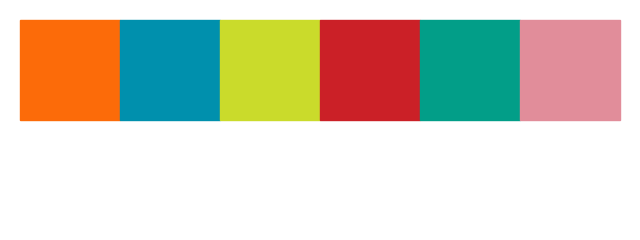

In [19]:
## Let's visualize the colors we used for plotting our RNA spots
distinctipy.color_swatch(colors)

## ROIs for each sample

In [9]:
genes_of_interest = ["Nppa","Nppb", "Acta2","Lyz2","Col1a1", "Pecam1"]
samples = ["sample_control_r1_s1","sample_4h_r1_s1","sample_2d_r1_s1","sample_4d_r1_s1"]
#samples = ["sample_4d_r1_s1"]
colors = ["#fc6b09","#0090ad","#cadb2b","#cb2027","#029e88", "#e18d9a"]

for sample in samples:
    napari_screenshot = '../../output/molkart_figure1_images/'+sample+'.napari_screen.roi_image.png'
    roi = pd.read_csv("../../data/molkart_tissue_regions_rois/"+sample+".figure_1_roi.csv")
    points =   pd.read_csv('../../../data/nf_molkart_results/dedup_spots/'+sample+'.spots_markedDups.txt', delimiter='\t', header=None)
    viewer = plot_points_napari(points_data = points,genes_of_interest = genes_of_interest, image= None, roi = roi, mask = None, color_palette= colors,pt_size=20,
                                output_path = napari_screenshot, scale_bar = True, font_size = 240, scale = 5, scalebar_length = 50,
                                img_type = "roi")

sample_control_r1_s1 1.0
sample_4h_r1_s1 1.1079881656804733
sample_2d_r1_s1 1.0067159167226327
sample_4d_r1_s1 1.0


# Create images for segmentation masks

In [12]:
samples = ["sample_control_r1_s1"]
img_dir = "../../../data/nf_molkart_results/preprocess/"
mask_dir = "../../../data/nf_molkart_results/retained_masks/"

In [113]:
# Create a napari viewer
viewer = napari.Viewer()

# Add the new mask to the viewer
viewer.add_labels(mask, name = "segmentation")

/Users/florian_wuennemann/miniconda3/envs/spatialomics_MI/lib/python3.11/site-packages/napari/_vispy/layers/image.py:274: UserWarning: data shape (8576, 17152) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
/Users/florian_wuennemann/miniconda3/envs/spatialomics_MI/lib/python3.11/site-packages/napari/_vispy/layers/image.py:274: UserWarning: data shape (8576, 17152) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(


<Labels layer 'segmentation' at 0x73504a9e50>

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the labeled image mask
mask = io.imread(mask_dir + "sample_control_r2_s1_cellpose.retained_masks.tif").astype(np.int16)

# Get the unique labels in the mask and their corresponding indices
unique_labels, label_indices = np.unique(mask, return_inverse=True)

# Assign a random label between 1 and 8 to each unique label index
new_categories = np.zeros(len(unique_labels), dtype=int)
new_categories[1:] = np.random.randint(1, 9, size=len(unique_labels)-1)

# Assign Category 0 to Label 0
new_categories[unique_labels == 0] = 0

# Create a new table with the Label and Category columns
category_table = pd.DataFrame({'Label': unique_labels, 'Category': new_categories})

# Assign a random label between 1 and 8 to each unique label index
new_labels = np.zeros(len(unique_labels), dtype=int)
new_labels[1:] = np.random.randint(1, 9, size=len(unique_labels)-1)

# Use np.take() to apply the new labels to the mask
new_mask = np.take(new_labels, label_indices).reshape(mask.shape)

# Create a table with a single entry per category in new_mask, and assign each entry a color from the colorblind palette in the seaborn package
categories = np.unique(new_mask)
colors = sns.color_palette('colorblind', len(categories))
color_table = pd.DataFrame({'Category': categories, 'Color': colors})

# Assign each individual label in new_mask the corresponding color value from the color table
color_dict = {0: 'black'}
for i, label in enumerate(categories[1:]):
    color_dict[label] = color_table.loc[color_table['Category'] == label, 'Color'].values[0]

# Create a napari viewer
viewer = napari.Viewer()

# Add the new mask to the viewer
viewer.add_labels(new_mask, color = color_dict)


/Users/florian_wuennemann/miniconda3/envs/spatialomics_MI/lib/python3.11/site-packages/napari/_vispy/layers/image.py:274: UserWarning: data shape (8576, 17152) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
/Users/florian_wuennemann/miniconda3/envs/spatialomics_MI/lib/python3.11/site-packages/napari/_vispy/layers/image.py:274: UserWarning: data shape (8576, 17152) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(


<Labels layer 'new_mask' at 0x735d8aec10>

In [154]:
create_colored_mask(mask_path = mask_dir + "sample_control_r2_s1_cellpose.retained_masks.tif", category_table = category_table, color_palette = "deep") 

/Users/florian_wuennemann/miniconda3/envs/spatialomics_MI/lib/python3.11/site-packages/napari/_vispy/layers/image.py:274: UserWarning: data shape (8576, 17152) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
/Users/florian_wuennemann/miniconda3/envs/spatialomics_MI/lib/python3.11/site-packages/napari/_vispy/layers/image.py:274: UserWarning: data shape (8576, 17152) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(


In [153]:
import numpy as np
import cv2
from skimage.segmentation import find_boundaries

def create_grey_mask(mask):
    # Erode the mask by 2 pixels to create a 2 pixel black outline around all labels
    kernel = np.ones((3, 3), np.uint8)
    eroded_mask = cv2.erode(mask, kernel, iterations=2)

    # Find the boundaries of each label
    boundaries = find_boundaries(eroded_mask, mode='inner')

    return boundaries

In [214]:
import numpy as np
from skimage.segmentation import find_boundaries
import napari

def create_boundaries(mask):
    # Find the boundaries of each label
    boundaries = find_boundaries(mask, mode='thick')

    return boundaries

def create_grey_mask(mask):
    # Create a new mask with all labels colored grey
    grey_mask = np.zeros_like(mask)
    grey_mask[mask > 0] = 128

    return grey_mask

In [220]:
boundaries_mask = create_boundaries(mask)
# Invert the boundaries mask to make the boundaries black
boundaries_mask = np.logical_not(boundaries_mask)
grey_mask = create_grey_mask(mask)

# Create a napari viewer
viewer = napari.Viewer()

# Add the new mask to the viewer
viewer.add_image(boundaries_mask,colormap='gray', contrast_limits=[0, 1])
viewer.add_labels(grey_mask)

/Users/florian_wuennemann/miniconda3/envs/spatialomics_MI/lib/python3.11/site-packages/napari/_vispy/layers/image.py:274: UserWarning: data shape (8576, 17152) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
/Users/florian_wuennemann/miniconda3/envs/spatialomics_MI/lib/python3.11/site-packages/napari/_vispy/layers/image.py:274: UserWarning: data shape (8576, 17152) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
/Users/florian_wuennemann/miniconda3/envs/spatialomics_MI/lib/python3.11/site-packages/napari/_vispy/layers/image.py:274: UserWarning: data shape (8576, 17152) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
/Users/florian_wuennemann/miniconda3/envs/spatialomics_MI/lib/python3.11/site-packages/napari/_vispy/layers/image.py:274: Us

<Labels layer 'grey_mask' at 0x2ad669a10>

/Users/florian_wuennemann/miniconda3/envs/spatialomics_MI/lib/python3.11/site-packages/napari/_vispy/layers/image.py:274: UserWarning: data shape (8576, 17152) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
/Users/florian_wuennemann/miniconda3/envs/spatialomics_MI/lib/python3.11/site-packages/napari/_vispy/layers/image.py:274: UserWarning: data shape (8576, 17152) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
/Users/florian_wuennemann/miniconda3/envs/spatialomics_MI/lib/python3.11/site-packages/napari/_vispy/layers/image.py:274: UserWarning: data shape (8576, 17152) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
/Users/florian_wuennemann/miniconda3/envs/spatialomics_MI/lib/python3.11/site-packages/napari/_vispy/layers/image.py:274: Us